<a href="https://colab.research.google.com/github/waltergkaturuza/Machine-Learning-for-Climate-and-Weather/blob/main/Physically_informed_parameterization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 2: Physically-Informed Parameterization

⛈ Welcome to the second exercise of the "Physics-Guided Machine Learning" e-learning module of ECMWF's MOOC on Machine Learning in Weather and Climate 🌤

By the end of this second exercise, you will:

1.   Understand how using physical knowledge to rescale a machine learning model's inputs can make it more robust and generalizable,
2.   Know how to use *custom data generators* to nonlinearly rescale inputs before feeding them to a neural network, and
3.   Practice what you will learn about parameterization in Tier 3 on a realistic research case. 

While this notebook's completion time may widely vary depending on your programming experience, we estimate it will take a minimum of 30 minutes and much longer if you decide to explore the source code. This notebook provides a minimal reproducible example of the work described in the following preprint:

[Beucler, Tom, Michael Pritchard, Janni Yuval, Ankitesh Gupta, Liran Peng, Stephan Rasp, Fiaz Ahmed et al. "Climate-invariant machine learning."](https://arxiv.org/abs/2112.08440), 

and contains a reduced version of our data.

We will be relying on Keras, whose documentation you can find [here](https://keras.io/), and TensorFlow, whose documentation you can find [here](https://www.tensorflow.org/). The notebooks assume that you will run them on Google Colab (Google Colab tutorial [at this link](https://colab.research.google.com/drive/16pBJQePbqkz3QFV54L4NIkOn1kwpuRrj)). 

While everything can be run locally and there are only a handful of lines that use Google specific libraries, we encourage beginners to use Google Colab not to run into [Python virtual environment](https://docs.python.org/3/tutorial/venv.html) issues. 

Before we get started, if you are struggling with some of the exercises, do not hesitate to:


*   Use a direct Internet search, or [stackoverflow](https://stackoverflow.com/)
*   Debug your program, e.g. by following [this tutorial](https://swcarpentry.github.io/python-novice-inflammation/11-debugging/index.html)
*   Use assertions, e.g. by following [this tutorial](https://swcarpentry.github.io/python-novice-inflammation/10-defensive/index.html)
*   Ask for help on the MOOC's Moodle Forum

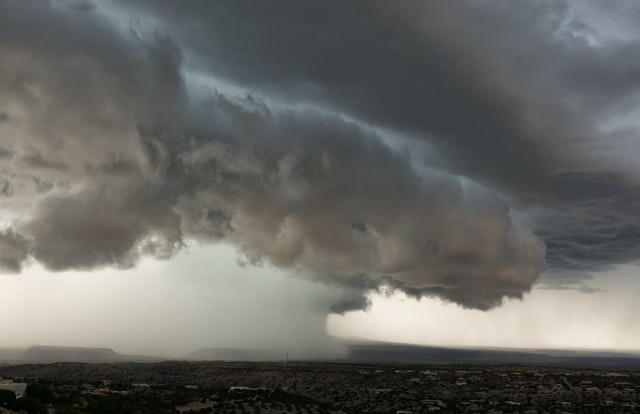

Storms rapidly transport heat and water in the atmosphere, regulating the Earth's climate. Can you predict how storms affect atmospheric temperatures using deep learning, even in a changing climate?

*Source: Photo by <a href="https://unsplash.com/@wildhoney?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">John Fowler</a> licensed under the <a href='https://unsplash.com/license'>Unsplash License.</a>*

## Part I: Configuration and Requirements

In [1]:
#@title  Run this cell for preliminary requirements. Double click for the source code
!pip install --no-binary 'shapely==1.6.4' 'shapely==1.6.4' --force
!pip install cartopy # Install latest version of cartopy
!pip install xarray # Install latest version of xarray
!pip install keras tensorflow # Install latest version of keras-tensorflow
!pip install h5py # Install latest version of h5py
!pip install scipy # Install latest version of scipy

DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 18.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for shapely: filename=Shapely-1.6.4-py2.py3-none-any.whl size=155989 sha256=ba782dfb4bd86c27df8d06e83f46136894a2617895ef5a015b3329ad686466c7
  Stored in directory: /root/.cache/pip/wheels/dc/05/15/e1e141104ee047b469ee5504b871a69bc51545e97bda105ca6
Successfully built shapely
  Attempting uninstall: shapely
    Found existing installation: 

In [2]:
#@title  Run this cell for Python library imports. Double click for the source code
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import scipy.integrate as sin
import tensorflow as tf
from tensorflow import keras
from keras.layers import *

import h5py
import pickle
import pooch
import xarray as xr

In [3]:
#@title Run this cell for figure aesthetics. Double click for the source code
fz = 15 # Here we define the fontsize 
lw = 2 # the linewidth
siz = 75 # and the scattered dots' size

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

In [4]:
#@title  Run this cell to load the data using the pooch library. Double click for the source code
path_data = 'https://unils-my.sharepoint.com/:u:/g/personal/tom_beucler_unil_ch/'

# Load simulation data
path_cold = path_data + 'EfHoI_pZY3xAi4bLEuDobaUBjyQmoJd1AvYnoPdH01VN-w?download=1'
path_warm = path_data + 'Eeq_n6Qv0jZBuRkICaOb0VQB6J1cN7muM6MrA3zA-v7LFg?download=1'
cold_open = pooch.retrieve(path_cold, known_hash='7b793afdd866a2e9b0db8fdb5029a88d557bf98525601275f5a335e95b26ac1a')
warm_open = pooch.retrieve(path_warm, known_hash='211db8ae89904f1fa3e2f17dc623bc6f5c6156cf24f4e3a42d92660ab1790fd4')
cold_data = xr.open_dataset(cold_open)
warm_data = xr.open_dataset(warm_open)

# Load normalization files
path_hyam_hybm = path_data + 'Eb3WRMTGuUJNmsywPZOr0HEB-ocxfu7UkFFteWU0SyVqdQ?download=1'
path_norm_raw = path_data + 'EbqnraroMS9OsYazoCKPvxoBi42jeBegusakwfbMtqUO3w?download=1'
path_norm_RH = path_data + 'Eb5Gsx1dm4dCnIASDm6Bc8gBgko9nP3GZVKdRDgleibuTA?download=1'
path_norm_B = path_data + 'EVDMLGtWwCtLpkACuzU-YaUBs-RnsdtlvREJLNpkuG1E9w?download=1'
path_norm_LHFnsDELQ = path_data + 'Edt4Mm1hBT9FrYM0Ngd273oB6K8TvGxcBco35SL_J_ZFZQ?download=1'
hyam_hybm_open = pooch.retrieve(path_hyam_hybm, known_hash='343339f9b0fd4d92a8a31aabf774c0a17b6ac904feb6a2cd03e19ae4ff2bd329')
norm_raw_open = pooch.retrieve(path_norm_raw, known_hash='ee3c669928031af1a03ec3bc61373107575173decf66ede9b0c3b8568214ca0f')
RH_open = pooch.retrieve(path_norm_RH, known_hash='4d5275746eb1aad4a2279e16784befaa4beeab5a2aa6545e0e85437c8d73476f')
B_open = pooch.retrieve(path_norm_B, known_hash='396df61a24f6111acc1b908cdda3d10e0649d3eb551de860b3ebeb4419adc514')
LHFnsDELQ_open = pooch.retrieve(path_norm_LHFnsDELQ, known_hash='514413a6ab0f33039df5f815a925cf8916454d288f384615050131f1bdc8b06f')
hyam_hybm = pickle.load(open(hyam_hybm_open,'rb'))
hyam,hybm = hyam_hybm
norm_raw = xr.open_dataset(norm_raw_open)
norm_RH = xr.open_dataset(RH_open)
norm_B = xr.open_dataset(B_open)
norm_LHFnsDELQ = xr.open_dataset(LHFnsDELQ_open)

# Load training files used to build the normalization data generators
path_train_RH = path_data + 'EWX9way46H9OvLLgLqPEr4QB4WkyTPDwGB7b-EjhTVIHww?download=1'
RH_train_open = pooch.retrieve(path_train_RH, known_hash='082cb63e5fbf315d8072a8d1613c8f0d810f949d32c9ad9374523b22de87a539')
path_train_BMSE = path_data + 'EU-cEsEjKT1Gn-s1aOGFMKgBK3C3yrAuxzX5_zaSIVOE-w?download=1'
BMSE_train_open = pooch.retrieve(path_train_BMSE,known_hash='cbc8e1736ffbbbc4b2c6a000cb32942abff73438157cb8e82e4195d76d0c5ccd')
path_train_LHFnsDELQ = path_data + 'ERojIn0ALWFMsPsknNqcOFMB5bL9nb1vPgPUlhO56sMe-Q?download=1'
LHFnsDELQ_train_open = pooch.retrieve(path_train_LHFnsDELQ,
                                      known_hash='afef6ba713cafda3cbf6c1189f7f96602b4f00507feae394c65f20362cb48ba7')

# Extract the range of possible longitude and latitude in case of need 
longitude = cold_data.lon[:144].values
latitude = cold_data.lat[:96*144:144].values
# SPCAM's background pressure coordinates (in hPa)
pressure_levels = np.array([ 3.643466, 7.59482 , 14.356632, 24.61222 ,
                            38.2683  , 54.59548 , 72.012451,  87.82123 ,
                            103.317127, 121.547241, 142.994039, 168.22508 ,
                            197.908087, 232.828619, 273.910817, 322.241902,
                            379.100904, 445.992574, 524.687175, 609.778695,
                            691.38943 , 763.404481, 820.858369, 859.534767,
                            887.020249, 912.644547, 936.198398, 957.48548 ,
                            976.325407, 992.556095])

## Part II: Visualizing the Extrapolation Problem

We've now extracted our cold simulation data as an [Xarray DataArray](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html) called `cold_data` and our 8K-warmer simulation data as another [Xarray DataArray](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html) called `warm_data`. 

Just in case you need it, we've also extracted all possible latitude values in `latitude` and all possible longitude values in `longitude`. The vertical pressure levels are given by `pressure_levels` (in hPa). 

We will soon visualize the data to give you more intuition about the prediction problem. We aim to predict the effect of ~5km-scale storm, clouds, and turbulence on the climate from the climate conditions (specific humidity `QBP` in kg/kg, temperature `TBP` in K, surface pressure `PS` in hPa, solar insolation `SOLIN` in $W/m^{2}$, surface sensible heat fluxes `SHFLX` in $W/m^{2}$ and surface latent heat fluxes `LHFLX` in $W/m^{2}$. 

As an example, we'll focus on predicting "subgrid heating tendencies" or `TPHYSTND` in $K/s$ at the model's vertical levels, which is the rate at which these storms, clouds, and turbulence warm up the atmosphere. However, you could reproduce the example below with `PHQ`, which contains the "subgrid *moistening* tendencies".

Therefore, our prediction problem can be mathematically phrased as a regression problem, in which we are trying to predict:  

`y = [ TPHYSTND[:30] ]`

from

`x = [ QBP[:30] , TBP[:30] , PS , SOLIN , SHFLX , LHFLX ]`,

where we use a vertical grid with 30 vertical levels, which means that the profiles of specific humidity `QBP` and temperature `TBP` both have 30 vertical levels, while the other inputs are scalars. 

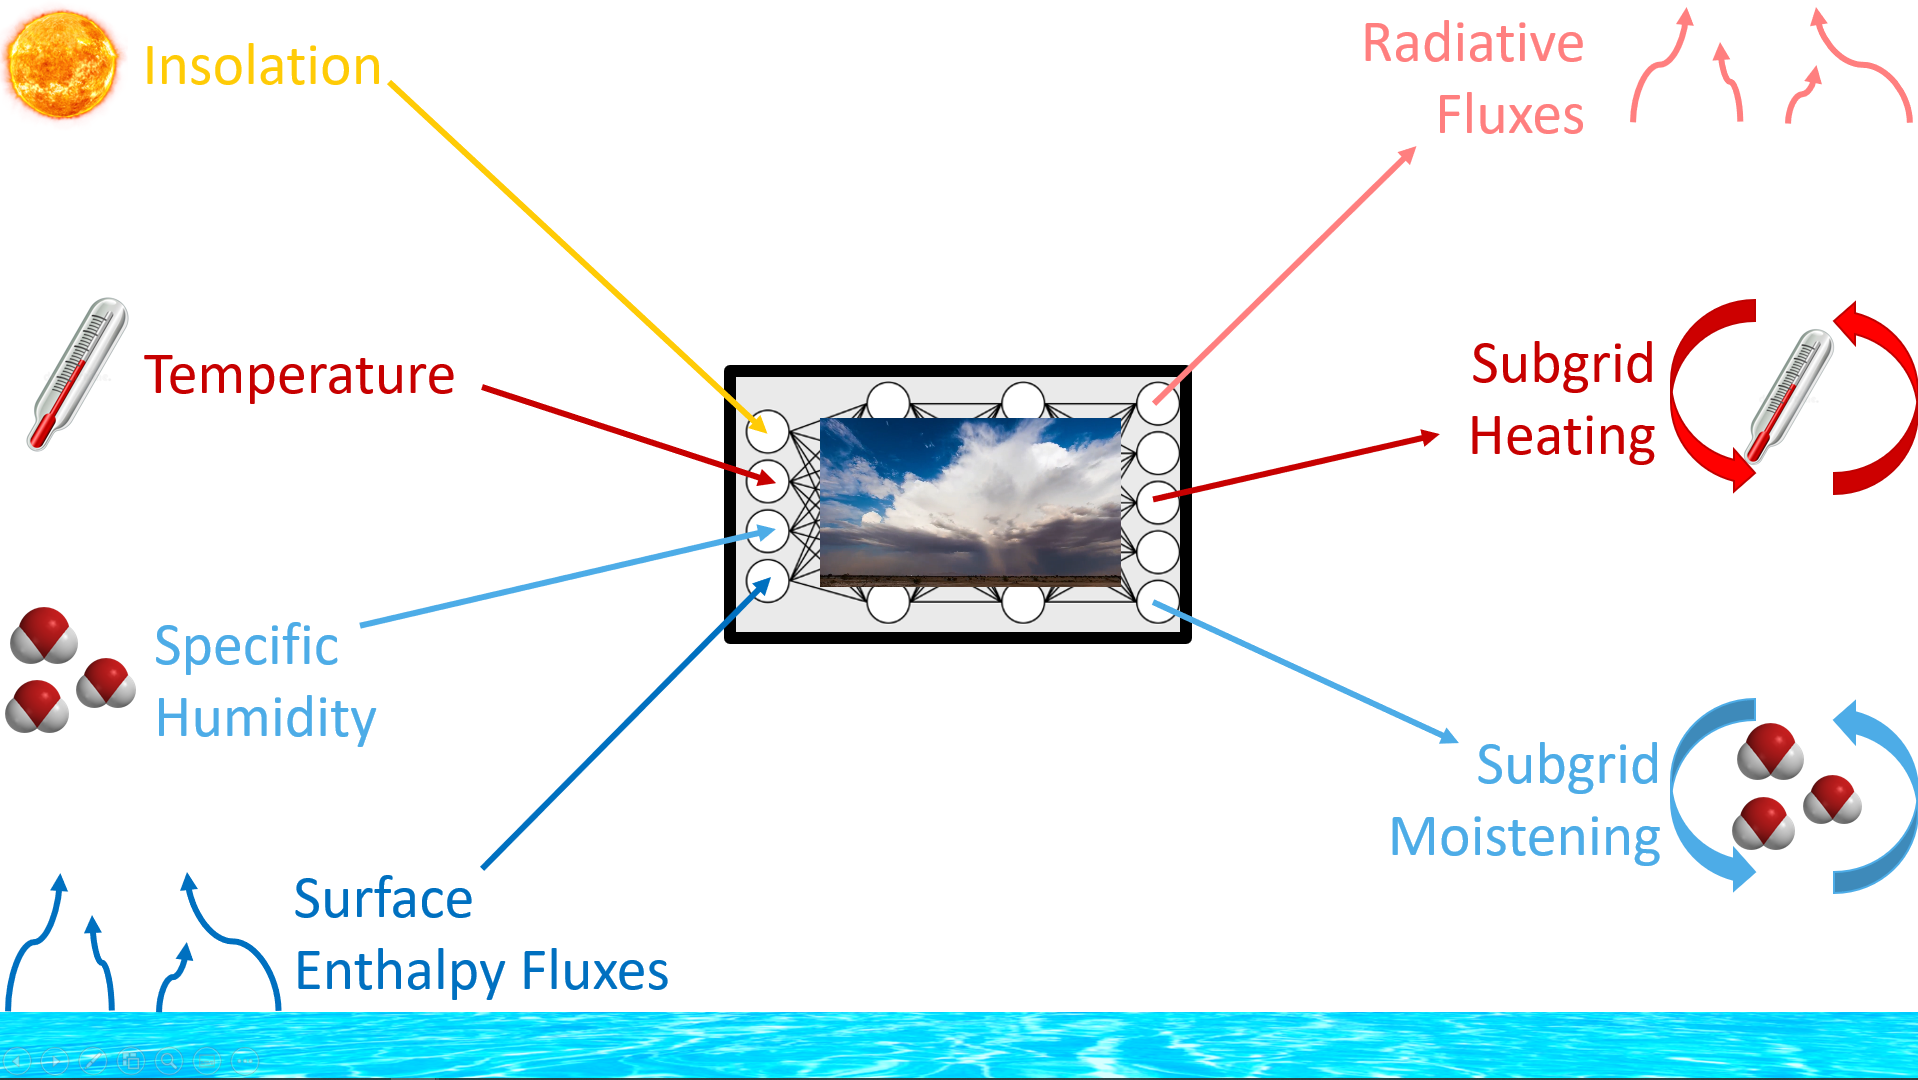

*The inputs or features (left) of a machine-learning parameterization are variables representing the large-scale climate properties, while the outputs or targets (right) are the rate at which storm-scale turbulence redistributes heat, moisture, and affects radiative fluxes.*

In [5]:
#@title  Run this cell to calculate spatial statistics of the specific humidity input. 
cold_q_m = {}; warm_q_m = {};
dictionary = ['mean','max','min']

for idic,m in enumerate(dictionary):
    cold_q_m[m] = np.zeros((len(latitude),len(longitude)))
    warm_q_m[m] = np.zeros((len(latitude),len(longitude)))

Nsample = (len(longitude)*len(latitude)) # Total number of samples

# First, convert the arrays to numpy to accelerate calculations
cold_q = cold_data['vars'][:,29].values
warm_q = warm_data['vars'][:,29].values

for ilat in range(len(latitude)):
    for ilon in range(len(longitude)):
        i_start = (ilat*len(longitude)+ilon) # First index corresponding to (lon,lat)

        cold_q_m['mean'][ilat,ilon] = np.mean(cold_q[i_start::Nsample])
        warm_q_m['mean'][ilat,ilon] = np.mean(warm_q[i_start::Nsample])

        cold_q_m['min'][ilat,ilon] = np.min(cold_q[i_start::Nsample])
        warm_q_m['min'][ilat,ilon] = np.min(warm_q[i_start::Nsample])

        cold_q_m['max'][ilat,ilon] = np.max(cold_q[i_start::Nsample])
        warm_q_m['max'][ilat,ilon] = np.max(warm_q[i_start::Nsample])

In [6]:
#@title  Run this cell to define a function plotting maps of these spatial statistics. 
def Input_map(cold_variable, warm_variable, cold_name, warm_name, var_name,
              vmin, vmax):
    '''
    Plots maps of the cold_variable (with the title "cold_name")
    next to the warm_variable (with the title "warm_name")
    and sets the colorbar's label to "var_name".
    The colorbar ranges from vmin to vmax. 
    '''
    fig, ax = plt.subplots(1,2,
                        subplot_kw={'projection':ccrs.Robinson(central_longitude=180)},
                        figsize=(12.5,5))

    cold = ax[0].pcolormesh(longitude,latitude,cold_variable,
                            transform=ccrs.PlateCarree(),
                            vmin=vmin,vmax=vmax)
    ax[0].set_title(cold_name)
    warm = ax[1].pcolormesh(longitude,latitude,warm_variable,
                            transform=ccrs.PlateCarree(),
                            vmin=vmin,vmax=vmax)
    ax[1].set_title(warm_name)

    for iplot in range(2):
        ax[iplot].coastlines(linewidth=2.0,edgecolor='0.25')
        ax[iplot].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

    cbar_ax = fig.add_axes([0.94,0.2,0.01,0.6])
    cbar = fig.colorbar(warm, label=var_name,cax=cbar_ax)
    cbar_ax.yaxis.set_ticks_position('right')
    cbar_ax.yaxis.set_label_position('right')

    return fig,ax

/usr/local/lib/python3.9/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.9/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


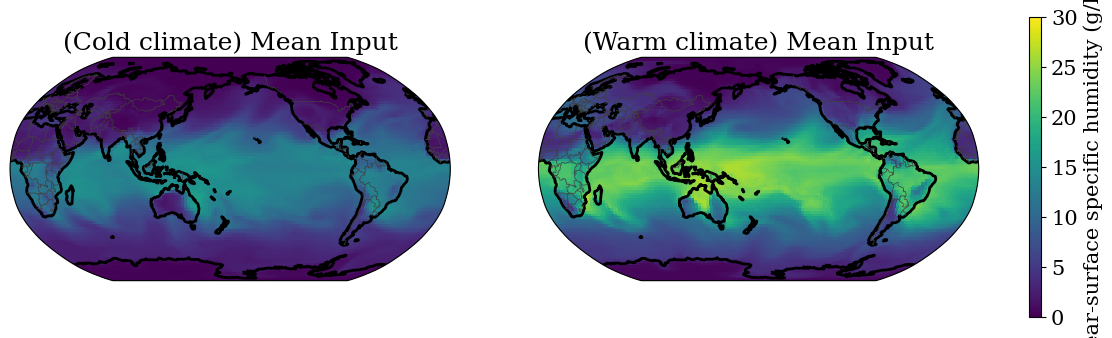

In [7]:
Input_map(1e3*cold_q_m['mean'], 1e3*warm_q_m['mean'],
          '(Cold climate) Mean Input', '(Warm climate) Mean Input',
          'Near-surface specific humidity (g/kg)', 0, 30);

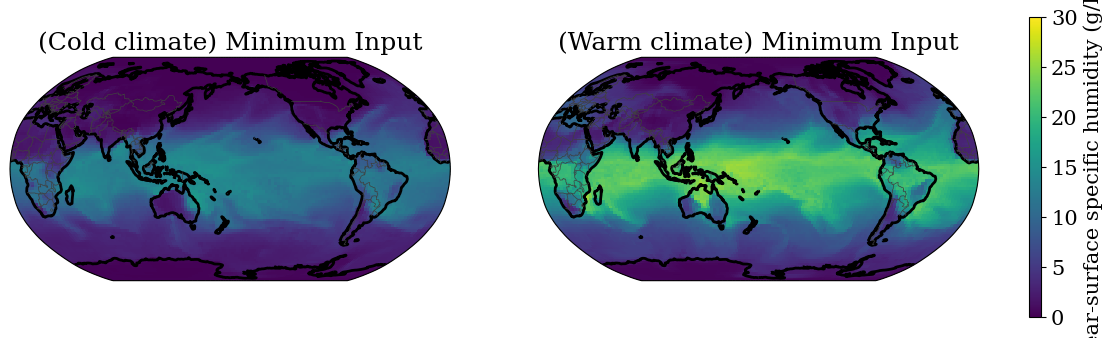

In [8]:
Input_map(1e3*cold_q_m['min'], 1e3*warm_q_m['min'],
          '(Cold climate) Minimum Input', '(Warm climate) Minimum Input',
          'Near-surface specific humidity (g/kg)', 0, 30);

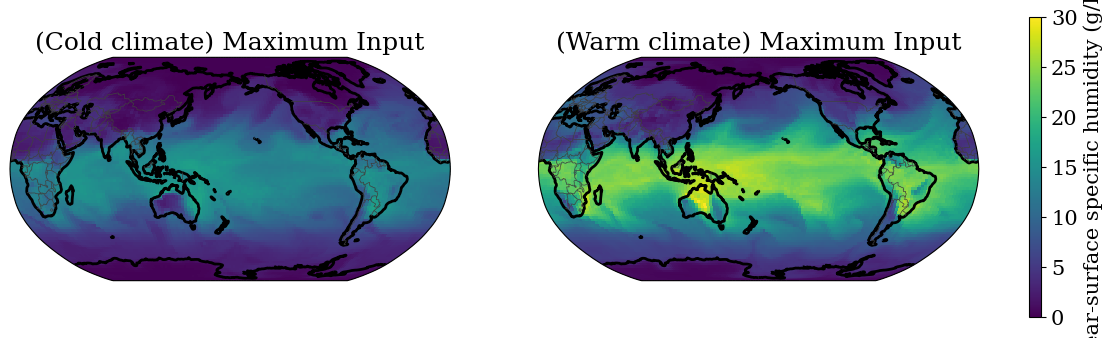

In [9]:
Input_map(1e3*cold_q_m['max'], 1e3*warm_q_m['max'],
          '(Cold climate) Maximum Input', '(Warm climate) Maximum Input',
          'Near-surface specific humidity (g/kg)', 0, 30);

As you can see, the warm climate contains values of the inputs (here, near-surface specific humidity) that were never seen during training. This means that even if we learn an excellent machine-learning parameterization in the cold climate, using this same machine-learning parameterization in a warm climate will be a challenging *extrapolation* problem. 

Two goals of this notebook will be to: 

1.   Expose the failure of a deep learning parameterization when generalizing from a cold climate to a warm climate. 
2.   Physically rescaling the inputs to minimize distribution changes across climates. This will improve the generalization ability of our deep learning algorithms.  


☁ Let's start right away with the first physical rescaling: specific humidity into relative humidity ☁

### **Q1) To avoid the extrapolation problems visualized above, transform specific humidity into relative humidity**

You may use the equations below, which are adapted from the [System for Atmospheric Modeling model](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021MS002968) for consistency with our storm-resolving data. Assuming you alreay calculated the saturation pressure of water vapor over liquid water $e_{liq}$ and the saturation pressure of water vapor over ice $e_{ice}$, the model calculates relative humidity in two steps. 

1.   It assumes that the system's combined saturation pressure is:

*    Equal to $e_{liq}$ for above-freezing temperatures ($T>273.16K$)
*    Equal to $e_{ice}$ for cold temperatures ($T<253.16K$)
*    A linear combination of the two in the intermediate range: 

$e_{sat}=\omega \times e_{liq} + (1-\omega) \times e_{ice}$

where the weight $\omega$ is defined as: 

$\omega = \frac{T-253.16K}{273.16K-253.16K}$.

2.    It then combines the ideal gas law and Dalton's law with the definition of relative humidity to calculate relative humidity as:

$RH = \frac{e}{e_{sat}} = \frac{R_v}{R_d} \times \frac{p}{e_{sat}} \times q_v$

where: 

*    $R_v \approx 287 J kg^{-1} K^{-1}$ is the specific ideal gas constant for water vapor
*    $R_d \approx 461 J kg^{-1} K^{-1}$ is the specific ideal gas constant for a standard dry air mixture
*    $p$ is air pressure
*    $q_v$ is specific humidity, or equivalently the water vapor mass concentration (in kg/kg)

In [10]:
# Assume you have access to specific humidity, temperature, and air pressure
# Remember Python indices are left-inclusive and right-exclusive
# (You can just run this cell)

specific_humidity = cold_data['vars'][:,:30] # in kg/kg
temperature = cold_data['vars'][:,30:60] # in K

P0 = 1e5 # Mean surface air pressure (Pa)
near_surface_air_pressure = cold_data['vars'][:,60]
# Formula to calculate air pressure (in Pa) using the hybrid vertical grid
# coefficients at the middle of each vertical level: hyam and hybm
air_pressure_Pa = np.outer(near_surface_air_pressure**0,P0*hyam) + \
np.outer(near_surface_air_pressure,hybm)

Our goal is to calculate relative humidity using the above equations. We'll assume we already have functions (below) giving us `e_{liq}` and `e_{ice}` as a function of air temperature `T`. These functions can be called using:

*    `eliq(temperature)`
*    `eice(temperature)`

In [11]:
#@title Source code for eliq(T) and esat(T): Do not forget to execute this cell
def eliq(T):
    """
    Function taking temperature (in K) and outputting liquid saturation
    pressure (in hPa) using a polynomial fit
    """
    a_liq = np.array([-0.976195544e-15,-0.952447341e-13,0.640689451e-10,
                              0.206739458e-7,0.302950461e-5,0.264847430e-3,
                              0.142986287e-1,0.443987641,6.11239921]);
    c_liq = -80
    T0 = 273.16
    return 100*np.polyval(a_liq,np.maximum(c_liq,T-T0))

def eice(T):
    """
    Function taking temperature (in K) and outputting ice saturation
    pressure (in hPa) using a polynomial fit
    """
    a_ice = np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,
                      0.602588177e-7,0.615021634e-5,0.420895665e-3,
                      0.188439774e-1,0.503160820,6.11147274]);
    c_ice = np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07])
    T0 = 273.16
    return (T>c_ice[0])*eliq(T)+\
    (T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
    (T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*\
                       (c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))

Hints:



*   You can often accelerate your calculations by converting [xarray DataArray](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html) into [numpy nd-arrays](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) using their [`values` method](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.values.html). You will load these values into memory when you do this, so it will increase RAM usage.
*   To implement $e_{sat}$, you may e.g., use [numpy's `where` function](https://numpy.org/doc/stable/reference/generated/numpy.where.html) or booleans.
*   Given that super-saturation is rare at climate timescales, you can optionally bound your relative humidity calculation by 1.


💡 **For all questions, you can write your own code or complete the proposed code by replacing the underscores with the appropriate script**

In [12]:
# Here's an empty code cell to look at the data, etc.
# You can add or remove code and text cells via the "Insert" menu

In [15]:
# Q1.1) Calculate the combined saturation water vapor pressure here

omega = (temperature - ___) / (___ - ___)

# Make sure your weight omega is always between 0 and 1
omega = ___

esat =  ___

UFuncTypeError: ignored

In [ ]:
# Q1.2) Calculate relative humidity here

relative_humidity = ___

In [ ]:
#@title A possible solution for Q1

# 1) Calculating saturation water vapor pressure
T0 = 273.16 # Freezing temperature in standard conditions
T00 = 253.16 # Temperature below which we use e_ice
omega = (temperature - T00) / (T0 - T00)
omega = np.maximum( 0, np.minimum( 1, omega ))

esat =  (temperature>T0) * eliq(temperature) + \
(temperature<T00) * eice(temperature)+\
(temperature<=T0) * (temperature>=T00) * \
(omega * eliq(temperature) + (1-omega) * eice(temperature))

# 2) Calculating relative humidity
Rd = 287 # Specific gas constant for dry air
Rv = 461 # Specific gas constant for water vapor

# We use the `values` method to convert Xarray DataArray into Numpy ND-Arrays
relative_humidity = Rv/Rd * air_pressure_Pa/esat.values * specific_humidity.values

### **Q2) Ensure that you mostly solved the extrapolation problem visualized in Part I**

For this purpose, let's repeat the visualization of near-surface humidity, but this time using **near-surface** *relative* instead of *specific* humidity.

In [ ]:
#@title First, let's automatize the relative humidity calculation...

def RH_from_climate(data):
    
    # 0) Extract specific humidity, temperature, and air pressure
    specific_humidity = data['vars'][:,:30] # in kg/kg
    temperature = data['vars'][:,30:60] # in K

    P0 = 1e5 # Mean surface air pressure (Pa)
    near_surface_air_pressure = data['vars'][:,60]
    # Formula to calculate air pressure (in Pa) using the hybrid vertical grid
    # coefficients at the middle of each vertical level: hyam and hybm
    air_pressure_Pa = np.outer(near_surface_air_pressure**0,P0*hyam) + \
    np.outer(near_surface_air_pressure,hybm)

    # 1) Calculating saturation water vapor pressure
    T0 = 273.16 # Freezing temperature in standard conditions
    T00 = 253.16 # Temperature below which we use e_ice
    omega = (temperature - T00) / (T0 - T00)
    omega = np.maximum( 0, np.minimum( 1, omega ))

    esat =  (temperature>T0) * eliq(temperature) + \
    (temperature<T00) * eice(temperature)+\
    (temperature<=T0) * (temperature>=T00) * \
    (omega * eliq(temperature) + (1-omega) * eice(temperature))

    # 2) Calculating relative humidity
    Rd = 287 # Specific gas constant for dry air
    Rv = 461 # Specific gas constant for water vapor

    # We use the `values` method to convert Xarray DataArray into Numpy ND-Arrays
    return Rv/Rd * air_pressure_Pa/esat.values * specific_humidity.values

... so that we can calculate relative humidity for both cold and warm climates. We can then extract **near-surface** (993hPa) humidity, which is the input variable that was clearly out-of-distribution when we used *specific* humidity. 

In [ ]:
RH_cold = RH_from_climate(cold_data) # Relative humidity for the cold simulation output
RH_warm = RH_from_climate(warm_data) # Relative humidity for the warm simulation output

near_surf_RH_cold = RH_cold[:,-1] # Near-surface relative humidity for the cold case
near_surf_RH_warm = RH_warm[:,-1] # Near-surface relative humidity for the warm case

In [ ]:
# First, calculate the spatial statistics of this new near-surface 
# relative humidity field. You may complete the code below or write your own. 
cold_RH_m = {}; warm_RH_m = {};
dictionary = ['mean','max','min']

for idic,m in enumerate(dictionary):
    cold_RH_m[m] = np.zeros((len(latitude),len(longitude)))
    warm_RH_m[m] = np.zeros((len(latitude),len(longitude)))

Nsample = (___*___) # Total number of samples

for ilat in range(___):
    for ilon in range(___):
        i_start = (ilat*len(longitude)+ilon) # First index corresponding to (lon,lat)

        cold_RH_m['mean'][ilat,ilon] = np.___(___[i_start::Nsample])
        warm_RH_m['mean'][ilat,ilon] = np.___(___[i_start::Nsample])

        cold_RH_m['min'][ilat,ilon] = np.___(___[i_start::Nsample])
        warm_RH_m['min'][ilat,ilon] = np.___(___[i_start::Nsample])

        cold_RH_m['max'][ilat,ilon] = np.___(___[i_start::Nsample])
        warm_RH_m['max'][ilat,ilon] = np.___(___[i_start::Nsample])

In [ ]:
# Visualize the mean near-surface relative humidity at each location
# You may use the Input_map function provided above
Input_map(___,___,___,___,___,___,___);

In [ ]:
# Visualize the maximum at each location

In [ ]:
# Visualize the minimum at each location

In [ ]:
#@title A possible solution for Q2

# Calculate relative humidity statistics in cold/warm simulation output
cold_RH_m = {}; warm_RH_m = {};
dictionary = ['mean','max','min']

for idic,m in enumerate(dictionary):
    cold_RH_m[m] = np.zeros((len(latitude),len(longitude)))
    warm_RH_m[m] = np.zeros((len(latitude),len(longitude)))

Nsample = (len(longitude)*len(latitude)) # Total number of samples

for ilat in range(len(latitude)):
    for ilon in range(len(longitude)):
        i_start = (ilat*len(longitude)+ilon) # First index corresponding to (lon,lat)

        cold_RH_m['mean'][ilat,ilon] = np.mean(near_surf_RH_cold[i_start::Nsample])
        warm_RH_m['mean'][ilat,ilon] = np.mean(near_surf_RH_warm[i_start::Nsample])

        cold_RH_m['min'][ilat,ilon] = np.min(near_surf_RH_cold[i_start::Nsample])
        warm_RH_m['min'][ilat,ilon] = np.min(near_surf_RH_warm[i_start::Nsample])

        cold_RH_m['max'][ilat,ilon] = np.max(near_surf_RH_cold[i_start::Nsample])
        warm_RH_m['max'][ilat,ilon] = np.max(near_surf_RH_warm[i_start::Nsample])

# Visualize the new relative humidity input
Input_map(1e2*cold_RH_m['mean'], 1e2*warm_RH_m['mean'],
          '(Cold climate) Mean Input', '(Warm climate) Mean Input',
          'Relative Humidity (%)', 0, 100);
Input_map(1e2*cold_RH_m['max'], 1e2*warm_RH_m['max'],
          '(Cold climate) Max Input', '(Warm climate) Max Input',
          'Relative Humidity (%)', 0, 100);
Input_map(1e2*cold_RH_m['min'], 1e2*warm_RH_m['min'],
          '(Cold climate) Min Input', '(Warm climate) Min Input',
          'Relative Humidity (%)', 0, 100);

😃 It looks like our input distribution is now quite similar in the cold and warm climates! Since the support (range) of the relative humidity is $\approx [0,1]$, we now expect to have mostly converted a difficult *extrapolation* case into an easier *interpolation* case. The rest of this notebook will explore the consequences of this **physical rescaling** for the performance and generalization ability of neural networks 🧠

It would take much more than the alloted 30 minutes to repeat the same physical rescaling in a data generator (also called data loader or data pipeline), so we directly give you the source code below. Run it if you would like to proceed, and read it if you want to dive into fun implementation details 🤓

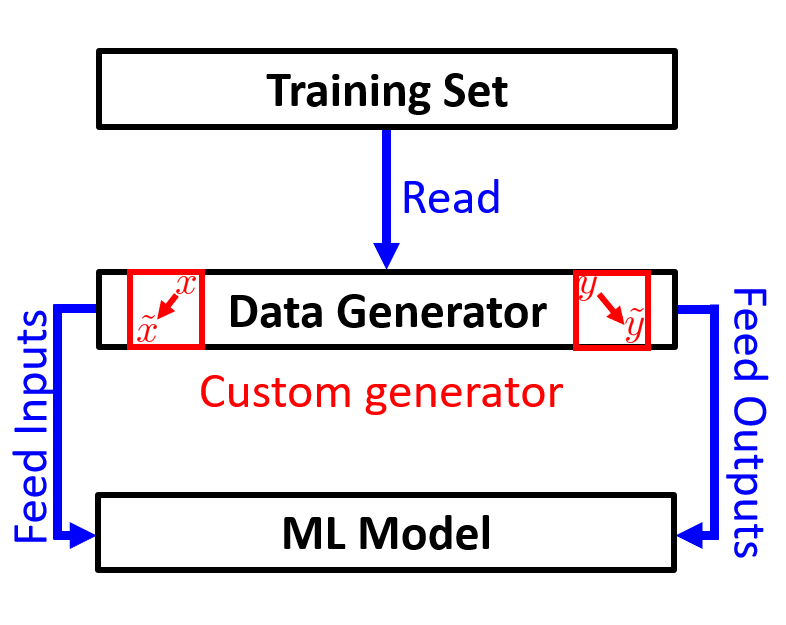

*Our custom data generator rescales the inputs $x$ to $\widetilde{x}$ before feeding them to the machine learning model for training.*

In [ ]:
#@title Source code for the moist thermodynamics library: Run to proceed and double click to read

# Constants for the Community Atmosphere Model
DT = 1800.
L_V = 2.501e6   # Latent heat of vaporization
L_I = 3.337e5   # Latent heat of freezing
L_F = L_I
L_S = L_V + L_I # Sublimation
C_P = 1.00464e3 # Specific heat capacity of air at constant pressure
G = 9.80616
RHO_L = 1e3

# Moist thermodynamics library in numpy
class CrhClass:
    def __init__(self):
        pass

    def eliq(self,T):
        a_liq = np.array([-0.976195544e-15,-0.952447341e-13,0.640689451e-10,0.206739458e-7,0.302950461e-5,0.264847430e-3,0.142986287e-1,0.443987641,6.11239921]);
        c_liq = -80
        T0 = 273.16
        return 100*np.polyval(a_liq,np.maximum(c_liq,T-T0))

    def eice(self,T):
        a_ice = np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,0.602588177e-7,0.615021634e-5,0.420895665e-3,0.188439774e-1,0.503160820,6.11147274]);
        c_ice = np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07])
        T0 = 273.16
        return (T>c_ice[0])*self.eliq(T)+\
    (T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
    (T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*(c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))

    def esat(self,T):
        T0 = 273.16
        T00 = 253.16
        omega = np.maximum(0,np.minimum(1,(T-T00)/(T0-T00)))

        return (T>T0)*self.eliq(T)+(T<T00)*self.eice(T)+(T<=T0)*(T>=T00)*(omega*self.eliq(T)+(1-omega)*self.eice(T))

    def RH(self,T,qv,P0,PS,hyam,hybm):
        R = 287
        Rv = 461
        S = PS.shape
        p = 1e5 * np.tile(hyam,(S[0],1))+np.transpose(np.tile(PS,(30,1)))*np.tile(hybm,(S[0],1))

        return Rv*p*qv/(R*self.esat(T))

    def qv(self,T,RH,P0,PS,hyam,hybm):
        R = 287
        Rv = 461
        S = PS.shape
        p = 1e5 * np.tile(hyam,(S[0],1))+np.transpose(np.tile(PS,(30,1)))*np.tile(hybm,(S[0],1))

        return R*self.esat(T)*RH/(Rv*p)


    def qsat(self,T,P0,PS,hyam,hybm):
        return self.qv(T,1,P0,PS,hyam,hybm)



    def dP(self,PS):
        S = PS.shape
        P = 1e5 * np.tile(hyai,(S[0],1))+np.transpose(np.tile(PS,(31,1)))*np.tile(hybi,(S[0],1))
        return P[:, 1:]-P[:, :-1]


class ThermLibNumpy:
    @staticmethod
    def eliqNumpy(T):
        a_liq = np.float32(np.array([-0.976195544e-15,-0.952447341e-13,\
                                     0.640689451e-10,\
                          0.206739458e-7,0.302950461e-5,0.264847430e-3,\
                          0.142986287e-1,0.443987641,6.11239921]));
        c_liq = np.float32(-80.0)
        T0 = np.float32(273.16)
        return np.float32(100.0)*np.polyval(a_liq,np.maximum(c_liq,T-T0))


    @staticmethod
    def eiceNumpy(T):
        a_ice = np.float32(np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,\
                          0.602588177e-7,0.615021634e-5,0.420895665e-3,\
                          0.188439774e-1,0.503160820,6.11147274]));
        c_ice = np.float32(np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07]))
        T0 = np.float32(273.16)
        return np.where(T>c_ice[0],ThermLibNumpy.eliqNumpy(T),\
                       np.where(T<=c_ice[1],np.float32(100.0)*(c_ice[3]+np.maximum(c_ice[2],T-T0)*\
                       (c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5])),\
                               np.float32(100.0)*np.polyval(a_ice,T-T0)))

    @staticmethod
    def esatNumpy(T):
        T0 = np.float32(273.16)
        T00 = np.float32(253.16)
        omtmp = (T-T00)/(T0-T00)
        omega = np.maximum(np.float32(0.0),np.minimum(np.float32(1.0),omtmp))

        return np.where(T>T0,ThermLibNumpy.eliqNumpy(T),np.where(T<T00,ThermLibNumpy.eiceNumpy(T),(omega*ThermLibNumpy.eliqNumpy(T)+(1-omega)*ThermLibNumpy.eiceNumpy(T))))

    @staticmethod
    def qvNumpy(T,RH,P0,PS,hyam,hybm):

        R = np.float32(287.0)
        Rv = np.float32(461.0)
        p = P0 * hyam + PS[:, None] * hybm # Total pressure (Pa)

        T = T.astype(np.float32)
        if type(RH) == int:
            RH = T**0
        RH = RH.astype(np.float32)
        p = p.astype(np.float32)

        return R*ThermLibNumpy.esatNumpy(T)*RH/(Rv*p)
        # DEBUG 1
        # return esat(T)

    @staticmethod
    def RHNumpy(T,qv,P0,PS,hyam,hybm):
        R = np.float32(287.0)
        Rv = np.float32(461.0)
        p = P0 * hyam + PS[:, None] * hybm # Total pressure (Pa)

        T = T.astype(np.float32)
        qv = qv.astype(np.float32)
        p = p.astype(np.float32)

        return Rv*p*qv/(R*ThermLibNumpy.esatNumpy(T))


    @staticmethod
    def qsatNumpy(T,P0,PS,hyam,hybm):
        return ThermLibNumpy.qvNumpy(T,1,P0,PS,hyam,hybm)


    @staticmethod
    def qsatsurfNumpy(TS,P0,PS):
        R = 287
        Rv = 461
        return R*ThermLibNumpy.esatNumpy(TS)/(Rv*PS)

    @staticmethod
    def dPNumpy(PS):
        S = PS.shape
        P = 1e5 * np.tile(hyai,(S[0],1))+np.transpose(np.tile(PS,(31,1)))*np.tile(hybi,(S[0],1))
        return P[:, 1:]-P[:, :-1]
    
    @staticmethod
    def theta_e_calc(T,qv,P0,PS,hyam,hybm):
        S = PS.shape
        p = P0 * np.tile(hyam,(S[0],1))+np.transpose(np.tile(PS,(30,1)))*np.tile(hybm,(S[0],1))
        tmelt  = 273.15
        CPD = 1005.7
        CPV = 1870.0
        CPVMCL = 2320.0
        RV = 461.5
        RD = 287.04
        EPS = RD/RV
        ALV0 = 2.501E6
        r = qv / (1. - qv)
        # get ev in hPa 
        ev_hPa = 100*p*r/(EPS+r)
        #get TL
        TL = (2840. / ((3.5*np.log(T)) - (np.log(ev_hPa)) - 4.805)) + 55.
        #calc chi_e:
        chi_e = 0.2854 * (1. - (0.28*r))
        P0_norm = (P0/(P0 * np.tile(hyam,(S[0],1))+np.transpose(np.tile(PS,(30,1)))*np.tile(hybm,(S[0],1))))
        theta_e = T * P0_norm**chi_e * np.exp(((3.376/TL) - 0.00254) * r * 1000. * (1. + (0.81 * r)))
        return theta_e
    
    @staticmethod
    def theta_e_sat_calc(T,P0,PS,hyam,hybm):
        return ThermLibNumpy.theta_e_calc(T,ThermLibNumpy.qsatNumpy(T,P0,PS,hyam,hybm),P0,PS,hyam,hybm) 
    
    @staticmethod
    def bmse_calc(T,qv,P0,PS,hyam,hybm):
        eps = 0.622 # Ratio of molecular weight(H2O)/molecular weight(dry air)
        R_D = 287 # Specific gas constant of dry air in J/K/kg
        Rv = 461
        # Calculate kappa
        QSAT0 = ThermLibNumpy.qsatNumpy(T,P0,PS,hyam,hybm)
        kappa = 1+(L_V**2)*QSAT0/(Rv*C_P*(T**2))
        # Calculate geopotential
        r = qv/(qv**0-qv)
        Tv = T*(r**0+r/eps)/(r**0+r)
        p = P0 * hyam + PS[:, None] * hybm
        p = p.astype(np.float32)
        RHO = p/(R_D*Tv)
        Z = -sin.cumtrapz(x=p,y=1/(G*RHO),axis=1)
        Z = np.concatenate((0*Z[:,0:1]**0,Z),axis=1)
        # Assuming near-surface is at 2 meters
        Z = (Z-Z[:,[29]])+2 
        # Calculate MSEs of plume and environment
        Tile_dim = [1,30]
        h_plume = np.tile(np.expand_dims(C_P*T[:,-1]+L_V*qv[:,-1],axis=1),Tile_dim)
        h_satenv = C_P*T+L_V*qv+G*Z
        return (G/kappa)*(h_plume-h_satenv)/(C_P*T)

# Physical rescalings
# Specific humidity to relative humidity
class QV2RHNumpy:
    def __init__(self, inp_sub, inp_div, inp_subRH, inp_divRH, hyam, hybm):
        self.inp_sub, self.inp_div, self.inp_subRH, self.inp_divRH, self.hyam, self.hybm = \
            np.array(inp_sub), np.array(inp_div), np.array(inp_subRH), np.array(inp_divRH), \
        np.array(hyam), np.array(hybm)
        # Define variable indices here
        # Input
        self.QBP_idx = slice(0,30)
        self.TBP_idx = slice(30,60)
        self.PS_idx = 60
        self.SHFLX_idx = 62
        self.LHFLX_idx = 63
    def process(self,X):
        Tprior = X[:,self.TBP_idx]*self.inp_div[self.TBP_idx]+self.inp_sub[self.TBP_idx]
        qvprior = X[:,self.QBP_idx]*self.inp_div[self.QBP_idx]+self.inp_sub[self.QBP_idx]
        PSprior = X[:,self.PS_idx]*self.inp_div[self.PS_idx]+self.inp_sub[self.PS_idx]
        RHprior = (ThermLibNumpy.RHNumpy(Tprior,qvprior,P0,PSprior,self.hyam,self.hybm)-\
                    self.inp_subRH[self.QBP_idx])/self.inp_divRH[self.QBP_idx]
        X_result = np.concatenate([RHprior.astype(np.float32),X[:,30:]], axis=1)
        return X_result

# Temperature to moist static energy-conserving plume buoyancy
class T2BMSENumpy:
    def __init__(self, inp_sub, inp_div, inp_subT, inp_divT, hyam, hybm):
        self.inp_sub, self.inp_div, self.inp_subT, self.inp_divT, self.hyam, self.hybm = \
            np.array(inp_sub), np.array(inp_div), np.array(inp_subT), np.array(inp_divT), \
        np.array(hyam), np.array(hybm)
        # Define variable indices here
        # Input
        self.QBP_idx = slice(0,30)
        self.TBP_idx = slice(30,60)
        self.PS_idx = 60
        self.SHFLX_idx = 62
        self.LHFLX_idx = 63
    def process(self,X):
        Tprior = X[:,self.TBP_idx]*self.inp_div[self.TBP_idx]+self.inp_sub[self.TBP_idx]
        qvprior = X[:,self.QBP_idx]*self.inp_div[self.QBP_idx]+self.inp_sub[self.QBP_idx]
        PSprior = X[:,self.PS_idx]*self.inp_div[self.PS_idx]+self.inp_sub[self.PS_idx]
        Bmse = ThermLibNumpy.bmse_calc(Tprior,qvprior,P0,PSprior,self.hyam,self.hybm)
        Bmseprior = (Bmse-self.inp_subT[self.TBP_idx])/self.inp_divT[self.TBP_idx]
        post = np.concatenate([X[:,:30],Bmseprior.astype(np.float32),X[:,60:]], axis=1)
        X_result = post
        return X_result

# Surface sensible heat fluxes to version of SHF normalized by
# near-surface temperature disequilibrium
class SHF2SHF_nsDELTNumpy:
    def __init__(self, inp_sub, inp_div, inp_subSHF, inp_divSHF, hyam, hybm, epsilon):
        self.inp_sub, self.inp_div, inp_subSHF, inp_divSHF, self.hyam, self.hybm, self.epsilon = \
        np.array(inp_sub), np.array(inp_div), \
        np.array(inp_subSHF), np.array(inp_divSHF), \
        np.array(hyam), np.array(hybm),np.array(epsilon)
        
        # Define variable indices here
        # Input
        self.QBP_idx = slice(0,30)
        self.TBP_idx = slice(30,60)
        self.PS_idx = 60
        self.SHFLX_idx = 62
        self.LHFLX_idx = 63
        
    def process(self,X):
        Tprior = X[:,self.TBP_idx]*self.inp_div[self.TBP_idx]+self.inp_sub[self.TBP_idx]
        SHFprior = X[:,self.SHFLX_idx]*self.inp_div[self.SHFLX_idx]+self.inp_sub[self.SHFLX_idx]
        
        #Tile_dim = [1,30]
        #TSprior = np.tile(np.expand_dims(Tprior[:,-1],axis=1),Tile_dim)
        Tdenprior = np.maximum(self.epsilon,TSprior-Tprior[:,-1])
        
        #SHFtile = np.tile(np.expand_dims(SHFprior,axis=1),Tile_dim)
        SHFscaled = (SHFprior/(C_P*Tdenprior)-\
                     self.inp_subT[self.TBP_idx])/self.inp_divT[self.TBP_idx]
        Tile_dim = [1,1]
        SHFtile = np.tile(np.expand_dims(SHFscaled.astype(np.float32),axis=1),Tile_dim)
        
        
        post = np.concatenate([X[:,:self.SHFLX_idx],SHFtile,X[:,self.LHFLX_idx:]], axis=1)
        
        X_result = post
        return post 

# Surface latent heat fluxes to version of LHF normalized by
# near-surface temperature disequilibrium
class LHF2LHF_nsDELQNumpy:
    def __init__(self, inp_sub, inp_div, inp_subLHF, inp_divLHF, hyam, hybm, epsilon):
        self.inp_sub, self.inp_div, self.inp_subLHF, self.inp_divLHF, self.hyam, self.hybm, self.epsilon = \
        np.array(inp_sub), np.array(inp_div), \
        np.array(inp_subLHF), np.array(inp_divLHF), \
        np.array(hyam), np.array(hybm),np.array(epsilon)
        
        # Define variable indices here
        # Input
        self.QBP_idx = slice(0,30)
        self.TBP_idx = slice(30,60)
        self.PS_idx = 60
        self.SHFLX_idx = 62
        self.LHFLX_idx = 63
        
    def process(self,X):
        qvprior = X[:,self.QBP_idx]*self.inp_div[self.QBP_idx]+self.inp_sub[self.QBP_idx]
        Tprior = X[:,self.TBP_idx]*self.inp_div[self.TBP_idx]+self.inp_sub[self.TBP_idx]
        PSprior = X[:,self.PS_idx]*self.inp_div[self.PS_idx]+self.inp_sub[self.PS_idx]
        LHFprior = X[:,self.LHFLX_idx]*self.inp_div[self.LHFLX_idx]+self.inp_sub[self.LHFLX_idx]
        
        Qdenprior = (ThermLibNumpy.qsatNumpy(Tprior,P0,PSprior,self.hyam,self.hybm))[:,-1]-qvprior[:,-1]
        Qdenprior = np.maximum(self.epsilon,Qdenprior)
        
        Tile_dim = [1,1]
        #LHFtile = np.tile(np.expand_dims(LHFprior,axis=1),Tile_dim)
        LHFscaled = (LHFprior/(L_V*Qdenprior)-\
                     self.inp_subLHF[self.LHFLX_idx])/self.inp_divLHF[self.LHFLX_idx]
        LHFtile = np.tile(np.expand_dims(LHFscaled.astype(np.float32),axis=1),Tile_dim)
        
        post = np.concatenate([X[:,:self.LHFLX_idx],LHFtile,\
                               X[:,(self.LHFLX_idx+1):]],axis=1)
        
        X_result = post
        return post

In [ ]:
#@title Source code for the custom data generator: Run to proceed and double click at your own risk

# Utility for the data generator
def return_var_idxs(ds, var_list, var_cut_off=None):
    """
    To be used on stacked variable dimension. Returns indices array
    Parameters
    ----------
    ds: xarray dataset
    var_list: list of variables
    Returns
    -------
    var_idxs: indices array
    """
    if var_cut_off is None:
        var_idxs = np.concatenate([np.where(ds.var_names == v)[0] for v in var_list])
    else:
        idxs_list = []
        for v in var_list:
            i = np.where(ds.var_names == v)[0]
            if v in var_cut_off.keys():
                i = i[var_cut_off[v]:]
            idxs_list.append(i)
        var_idxs = np.concatenate(idxs_list)
    return var_idxs

# Input normalization
class Normalizer(object):
    """Base normalizer class. All normalization classes must have a transform method."""
    def __init__(self):
        self.transform_arrays = None

    def transform(self, x):
        return x

class InputNormalizer(object):
    """Normalizer that subtracts and then divides."""
    def __init__(self, norm_ds, var_list, sub='mean', div='std_by_var', var_cut_off=None):
        var_idxs = return_var_idxs(norm_ds, var_list, var_cut_off)
        self.sub = norm_ds[sub].values[var_idxs]
        if div == 'maxrs':
            rang = norm_ds['max'][var_idxs] - norm_ds['min'][var_idxs]
            std_by_var = rang.copy()
            for v in var_list:
                std_by_var[std_by_var.var_names == v] = norm_ds['std_by_var'][
                    norm_ds.var_names_single == v]
            self.div = np.maximum(rang, std_by_var).values
        elif div == 'std_by_var':
            # SR: Total mess. Should be handled better
            tmp_var_names = norm_ds.var_names[var_idxs]
            self.div = np.zeros(len(tmp_var_names))
            for v in var_list:
                std_by_var = norm_ds['std_by_var'][norm_ds.var_names_single == v]
                self.div[tmp_var_names == v] = std_by_var
        else:
            self.div = norm_ds[div].values[var_idxs]
        self.transform_arrays = {
            'sub': self.sub,
            'div': self.div
        }

    def transform(self, x):
        return (x - self.sub) / self.div

    def inverse_transform(self, x):
        return (x * self.div) + self.sub

# Data generator class from https://github.com/raspstephan/CBRAIN-CAM/blob/master/cbrain/data_generator.py
class DataGenerator(tf.keras.utils.Sequence):
    """
    https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    Data generator class.
    """

    def __init__(self, data_fn, input_vars, output_vars,
                 norm_fn=None, input_transform=None, output_transform=None,
                 batch_size=1024, shuffle=True, xarray=False, var_cut_off=None):
        # Just copy over the attributes
        self.data_fn, self.norm_fn = data_fn, norm_fn
        self.input_vars, self.output_vars = input_vars, output_vars
        self.batch_size, self.shuffle = batch_size, shuffle

        # Open datasets
        self.data_ds = xr.open_dataset(data_fn)
        if norm_fn is not None: self.norm_ds = xr.open_dataset(norm_fn)

        # Compute number of samples and batches
        self.n_samples = self.data_ds.vars.shape[0]
        self.n_batches = int(np.floor(self.n_samples) / self.batch_size)

        # Get input and output variable indices
        self.input_idxs = return_var_idxs(self.data_ds, input_vars, var_cut_off)
        self.output_idxs = return_var_idxs(self.data_ds, output_vars)
        self.n_inputs, self.n_outputs = len(self.input_idxs), len(self.output_idxs)

        # Initialize input and output normalizers/transformers
        if input_transform is None:
            self.input_transform = Normalizer()
        elif type(input_transform) is tuple:
            self.input_transform = InputNormalizer(
                self.norm_ds, input_vars, input_transform[0], input_transform[1], var_cut_off)
        else:
            self.input_transform = input_transform  # Assume an initialized normalizer is passed

        if output_transform is None:
            self.output_transform = Normalizer()
        elif type(output_transform) is dict:
            self.output_transform = DictNormalizer(self.norm_ds, output_vars, output_transform)
        else:
            self.output_transform = output_transform  # Assume an initialized normalizer is passed

        # Now close the xarray file and load it as an h5 file instead
        # This significantly speeds up the reading of the data...
        if not xarray:
            self.data_ds.close()
            self.data_ds = h5py.File(data_fn, 'r')

    def __len__(self):
        return self.n_batches

    def __getitem__(self, index):
        # Compute start and end indices for batch
        start_idx = index * self.batch_size
        end_idx = start_idx + self.batch_size

        # Grab batch from data
        batch = self.data_ds['vars'][start_idx:end_idx]

        # Split into inputs and outputs
        X = batch[:, self.input_idxs]
        Y = batch[:, self.output_idxs]

        # Normalize
        X = self.input_transform.transform(X)
        Y = self.output_transform.transform(Y)

        return X, Y

    def on_epoch_end(self):
        self.indices = np.arange(self.n_batches)
        if self.shuffle: np.random.shuffle(self.indices)

# The custom generator class, inheriting the data generator class above
class DataGeneratorCI(DataGenerator):
    def __init__(self, data_fn, input_vars, output_vars,
             norm_fn=None, input_transform=None, output_transform=None,
             batch_size=1024, shuffle=True, xarray=False, var_cut_off=None, 
             Qscaling=None,
             Tscaling=None,
             LHFscaling=None,
             SHFscaling=None,
             output_scaling=False,
             interpolate=False,
             hyam=None,hybm=None,
             inp_sub_Qscaling=None,inp_div_Qscaling=None,
             inp_sub_Tscaling=None,inp_div_Tscaling=None,
             inp_sub_LHFscaling=None,inp_div_LHFscaling=None,
             inp_sub_SHFscaling=None,inp_div_SHFscaling=None,
             lev=None, interm_size=40,
             lower_lim=6,
             is_continous=True,Tnot=5,epsQ=1e-3,epsT=1,
                 mode='train'):
        self.output_scaling = output_scaling
        self.interpolate = interpolate
        self.Qscaling = Qscaling
        self.Tscaling = Tscaling
        self.LHFscaling = LHFscaling
        self.SHFscaling = SHFscaling
        self.inp_shape = 64
        self.mode=mode
        super().__init__(data_fn, input_vars,output_vars,norm_fn,input_transform,output_transform,
                        batch_size,shuffle,xarray,var_cut_off) ## call the base data generator
        self.inp_sub = self.input_transform.sub
        self.inp_div = self.input_transform.div
        if Qscaling=='RH':
            self.QLayer = QV2RHNumpy(self.inp_sub,self.inp_div,inp_sub_Qscaling,inp_div_Qscaling,hyam,hybm)
        elif Qscaling=='QSATdeficit':
            self.QLayer = QV2QSATdeficitNumpy(self.inp_sub,self.inp_div,inp_sub_Qscaling,inp_div_Qscaling,hyam,hybm)
        if Tscaling=='TfromNS':
            self.TLayer = T2TmTNSNumpy(self.inp_sub,self.inp_div,inp_sub_Tscaling,inp_div_Tscaling,hyam,hybm)
        elif Tscaling=='BCONS':
            self.TLayer = T2BCONSNumpy(self.inp_sub,self.inp_div,inp_sub_Tscaling,inp_div_Tscaling,hyam,hybm)
        elif Tscaling=='BMSE':
            self.TLayer = T2BMSENumpy(self.inp_sub,self.inp_div,inp_sub_Tscaling,inp_div_Tscaling,hyam,hybm)
        elif Tscaling=='T_NSto220':
            self.TLayer = T2T_NSto220Numpy(self.inp_sub,self.inp_div,inp_sub_Tscaling,inp_div_Tscaling,hyam,hybm)
        if LHFscaling=='LHF_nsDELQ':
            self.LHFLayer = LHF2LHF_nsDELQNumpy(self.inp_sub,self.inp_div,inp_sub_LHFscaling,inp_div_LHFscaling,hyam,hybm,epsQ)
        elif LHFscaling=='LHF_nsQ':
            self.LHFLayer = LHF2LHF_nsQNumpy(self.inp_sub,self.inp_div,inp_sub_LHFscaling,inp_div_LHFscaling,hyam,hybm,epsQ)
        if SHFscaling=='SHF_nsDELT':
            self.SHFLayer = SHF2SHF_nsDELTNumpy(self.inp_sub,self.inp_div,inp_sub_SHFscaling,inp_div_SHFscaling,hyam,hybm,epsT)
        if output_scaling:
            self.scalingLayer = ScalingNumpy(hyam,hybm)
            self.inp_shape += 1
        if interpolate:
            self.interpLayer = InterpolationNumpy(lev,is_continous,Tnot,lower_lim,interm_size)
            self.inp_shape += interm_size*2 + 4 + 30 ## 4 same as 60-64 and 30 for lev_tilde.size
    def __getitem__(self, index):
        # Compute start and end indices for batch
        start_idx = index * self.batch_size
        end_idx = start_idx + self.batch_size
        # Grab batch from data
        batch = self.data_ds['vars'][start_idx:end_idx]
        # Split into inputs and outputs
        X = batch[:, self.input_idxs]
        Y = batch[:, self.output_idxs]
        # Normalize
        X_norm = self.input_transform.transform(X)
        Y = self.output_transform.transform(Y)
        X_result = np.copy(X_norm)
        if self.Qscaling:
            X_result = self.QLayer.process(X_result)
        if self.Tscaling:
            # tgb - 3/21/2021 - BCONS needs qv in kg/kg as an input
            if self.Tscaling=='BCONS' or self.Tscaling=='BMSE':
                if self.Qscaling:
                    X_resultT = self.TLayer.process(X_norm)
                    X_result = np.concatenate([X_result[:,:30],X_resultT[:,30:60],X_result[:,60:]], axis=1)
                else:
                    X_result = self.TLayer.process(X_result)
            else:
                X_result = self.TLayer.process(X_result)
        if self.SHFscaling:
            X_result = self.SHFLayer.process(X_result)
        if self.LHFscaling:
            # tgb - 3/22/2021 - LHF_ns(DEL)Q needs qv in kg/kg and T in K
            if self.Qscaling or self.Tscaling:
                X_resultLHF = self.LHFLayer.process(X_norm)
                X_result = np.concatenate([X_result[:,:60],X_resultLHF[:,60:]],axis=1)
            else:
                X_result = self.LHFLayer.process(X_result)
        if self.output_scaling:
            scalings = self.scalingLayer.process(X)
            X_result = np.hstack((X_result,scalings))
        if self.interpolate:
            interpolated = self.interpLayer.process(X,X_result)
            X_result = np.hstack((X_result,interpolated))
        if self.mode=='val':
            return xr.DataArray(X_result), xr.DataArray(Y)
        return X_result,Y
    ##transforms the input data into the required format, take the unnormalized dataset
    def transform(self,X):
        X_norm = self.input_transform.transform(X)
        X_result = X_norm
        if self.Qscaling:
            X_result = self.QLayer.process(X_result)
        if self.Tscaling:
            X_result = self.TLayer.process(X_result)
        if self.SHFscaling:
            X_result = self.SHFLayer.process(X_result)
        if self.LHFscaling:
            X_result = self.LHFLayer.process(X_result)
        if self.scaling:
            scalings = self.scalingLayer.process(X)
            X_result = np.hstack((X_result,scalings))
        if self.interpolate:
            interpolated = self.interpLayer.process(X,X_result)
            X_result = np.hstack((X_result,interpolated))
        return X_result

## Part III: Exposing the Generalization Problem of Standard Neural Networks

The first step, which does not even require anything custom, is to show that neural network subgrid parameterizations trained on cold simulation output struggle to generalize to warm simulation output. 

✍ To practice, we will still use the custom data generator class `DataGeneratorCI` and choose the arguments so as not to apply any physical rescaling. 

In [ ]:
# Training generator loading data from the cold climate
train_gen_cold = DataGeneratorCI(
    data_fn = cold_open, # path to cold climate data
    input_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX'], # inputs/features
    output_vars = ['TPHYSTND'], # outputs/targets
    norm_fn = norm_raw_open, # input normalization constants
    input_transform = ('mean', 'maxrs'), # inputnormalization transform
    output_transform = None # output transform -- None needed here
    )

### **Q3) Create a standard neural network using the hyperparameters of your choice**

We'll refer to this standard (non physically-rescaled) neural network as "brute-force" (BF). The solution gives suggested parameters but we encourage you to be creative here 🎨

Given the environment of this notebook, we highly encourage you to use the [Keras functional API](https://keras.io/guides/functional_api/) to design your neural network. [Keras has helpful tutorials and an extensive documentation if you're not yet used to training neural networks.](https://keras.io/guides/functional_api/)

In [ ]:
inp_BF = Input(shape=(64,)) # We start from 64 inputs

# Be creative here
layer_1 = ___(___, activation=___)(inp_BF)
layer_2 = ___
layer_n = ___

out_BF = Dense(30, activation='linear')(layer_n) # We need to end up with 30 outputs

NN_BF = keras.Model(inputs=inp_BF,outputs=out_BF) # Brute-force model

In [ ]:
# Run this cell to check whether the neural network's architecture
# corresponds to what you had in mind
NN_BF.summary()

In [ ]:
#@title A possible solution for Q3

# 1) Create a generic NN model with 7 layers of 128 neurons and 
# Leaky Rectified Linear Unit activation functions
def NN_model(inp):
    densout = Dense(128, activation='linear')(inp)
    densout = LeakyReLU(alpha=0.3)(densout)
    for i in range (6):
        densout = Dense(128, activation='linear')(densout)
        densout = LeakyReLU(alpha=0.3)(densout)
    dense_out = Dense(30, activation='linear')(densout)
    return tf.keras.models.Model(inp, dense_out)

# 2) Create an instance of this generic NN for the brute-force model
inp_BF = Input(shape=(64,))
NN_BF = NN_model(inp_BF) # Brute-force model

### **Q4) Compile your neural network using an optimizer and a loss function that are adapted for multivariate regression problems**

Hints: 



1.   [Here's a list](https://keras.io/api/optimizers/) of easily-accessible optimizers in Keras. Our go-to was the [Adam optimizer](https://keras.io/api/optimizers/adam/), but the best optimizer will depend on your model's architecture and loss function.  
2.   [Here's a list](https://keras.io/api/losses/) of easily-accessible losses in Keras. Our go-to was the [mean-squared error](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError) (a safe bet for multivariate regression problems with well-behaved distributions) but nothing prevents you from being more creative 🎨



In [ ]:
NN_BF.compile(tf.keras.optimizers.___, loss=___)

In [ ]:
#@title A possible solution for Q4

mse = tf.keras.losses.MeanSquaredError() # Instantiate an unweighted MSE loss
# Compile the neural network for training
NN_BF.compile(tf.keras.optimizers.Adam(), loss=mse)

Now it's time for a little trick 🎪 We'll introduce a custom [callback](https://keras.io/api/callbacks/) that allows us to measure the loss on the warm climate dataset at the end of every epoch. That way, we'll see whether training our neural network is helping or harming its ability to make prediction in the warm climate. 

In [ ]:
#@title Simply run this cell to create the custom callback class "AdditionalValidationSets"

# From https://stackoverflow.com/questions/47731935/using-multiple-validation-sets-with-keras
class AdditionalValidationSets(keras.callbacks.Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            valid_generator,valid_name = validation_set
            results = self.model.evaluate(valid_generator)

            for metric, result in zip(self.model.metrics_names,[results]):
                valuename = valid_name + '_' + metric
                self.history.setdefault(valuename, []).append(result)

We can now use this callback to track the loss on the warm simulation output.

Note: This `AdditionalValidationSets` callback is a bit of an overkill because we could have defined the warm climate as our validation set, which is enough to track the loss at the end of every epoch in Keras. However, this callback comes in very handy if we would like to use more than one validation set! 😎

In [ ]:
# Validation generator loading data from the warm climate
valid_gen_warm = DataGeneratorCI(
    data_fn = warm_open, # path to cold climate data
    input_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX'], # inputs/features
    output_vars = ['TPHYSTND'], # outputs/targets
    norm_fn = norm_raw_open, # input normalization constants
    input_transform = ('mean', 'maxrs'), # inputnormalization transform
    output_transform = None # output transform -- None needed here
    )

# Instantiate a callback tracking the loss in the warm climate
learning_curve_BF = AdditionalValidationSets([(valid_gen_warm,'Generalization to warm climate')])

### **Q5) Train a "brute-force" neural net and track its loss on both the cold and warm data**

⚠ There is a high risk of overfitting the (cold) training set if your neural network has a lot of trainable parameters (weights/biases) and you train it for too many epochs ⚠

Because of time limitations, we are not optimally using the information from the cold climate. Best practices would recommend splitting the cold climate into several training/validation folds that we would use to avoid overfitting and optimize the hyperparameters, including the epoch used to save the best weights and biases for the neural network. 

In our [preprint](https://arxiv.org/abs/2112.08440), we show that even if one is careful not to overfit the training set in the cold climate, "brute-force" neural networks will still fail to generalize to much warmer climates (8K here). 

In [ ]:
# Enables tensorflow with GPU on Google Colab
# From https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=sXnDmXR7RDr2
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
# Complete the code below to train your brute-force neural network
Nep = __ # Choose your number of epochs depending on the time you have (e.g., 10)
NN_BF.___(___, epochs = ___, callbacks = ___)

In [ ]:
#@title A possible solution for Q5

Nep = 10 # Number of epochs
NN_BF.fit(train_gen_cold, epochs=Nep, callbacks=[learning_curve_BF])

See below for Q5's training *without* a GPU accelerator. 🐢

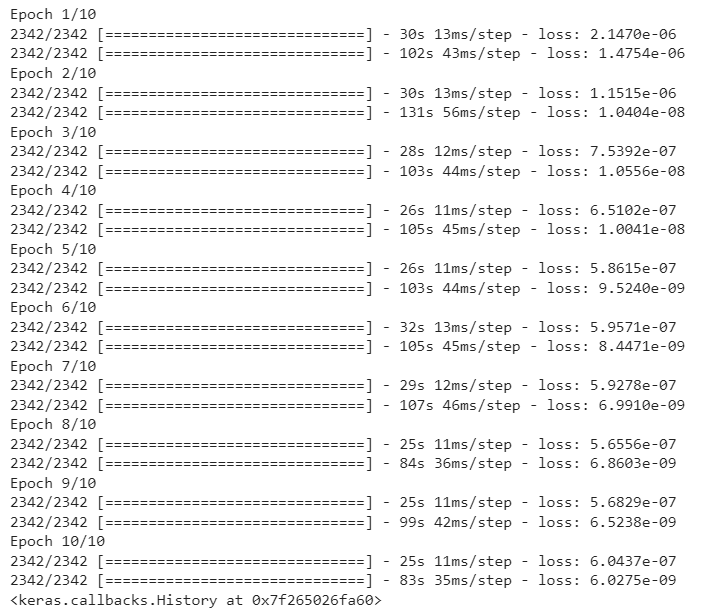

And see below for Q5's training *with* a GPU accelerator. Quite a bit faster, isn't it? 🚅

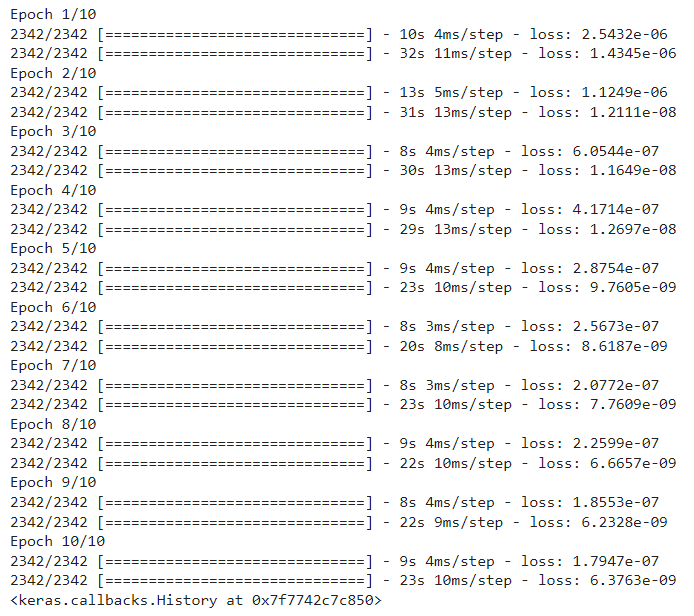

Let's now compare the losses in the cold and the warm climate. They may be so different that we use a log scale on the right-hand side panel. 

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12.5,5))

cold_BFloss = learning_curve_BF.history['loss']
warm_BFloss = learning_curve_BF.history['Generalization to warm climate_loss']
epoch = np.arange(1,len(cold_BFloss)+1)

for iplot in range(2):
  ax[iplot].plot(epoch,cold_BFloss,color='b')
  ax[iplot].scatter(epoch,cold_BFloss,color='b',label='Cold')
  ax[iplot].plot(epoch,warm_BFloss,color='r')
  ax[iplot].scatter(epoch,warm_BFloss,color='r',label='Warm')
  if iplot==1: plt.yscale('log')
  ax[iplot].set_xlabel('Number of Epochs')

plt.legend()

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.suptitle('User-chosen loss based on subgrid heating in units [K/s]');

As we can see, our brute-force network struggles to generalize from the cold (blue) to the warm (red) climate, except for very specific choices of architectures. This suggests that the mapping learned by the neural network is **not** climate-invariant, as it cannot transfer from the cold to the warm climate.

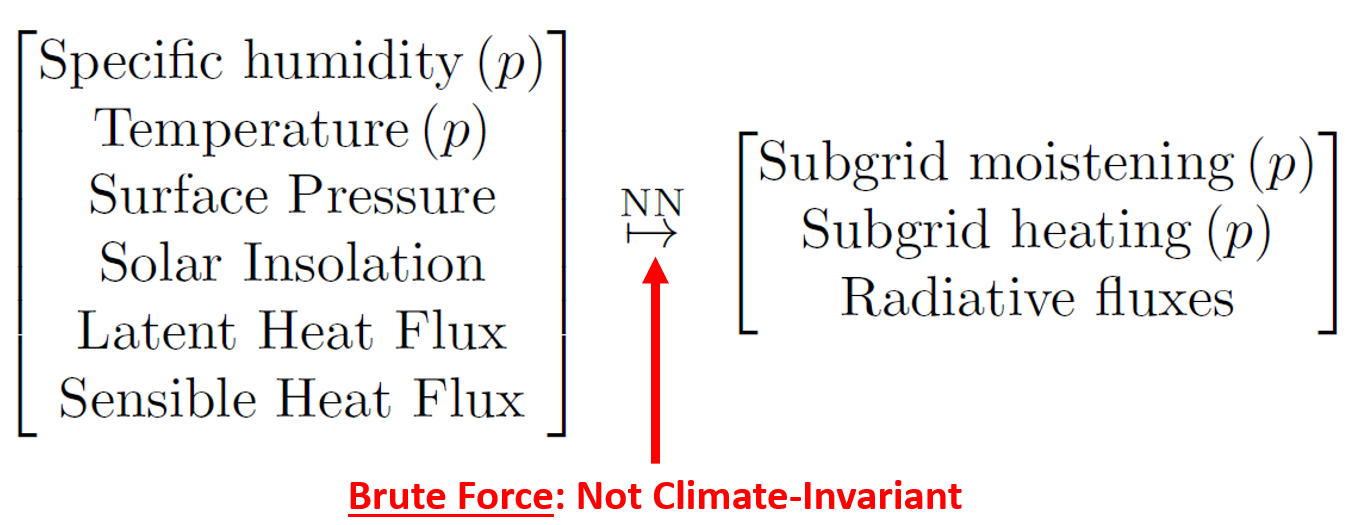

In the next part and inspired by your earlier result in Q2, we will explore how rescaling specific humidity to relative humidity can help your neural networks generalize across climates. 

## Part IV: Physically Rescaling the Inputs to Facilitate Generalization across Climates

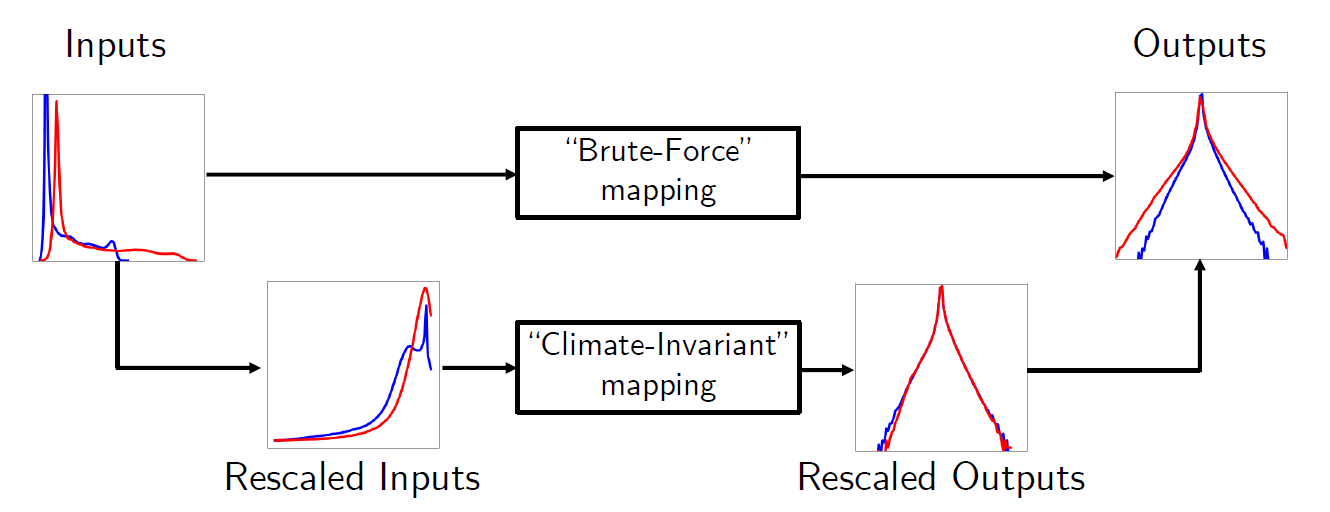

*The generalization issue we just observed suggests that the "brute-force" mapping from raw inputs to raw outputs is not the same in the cold and in the warm climate, leading to a generalization problem. Can we find a way to rescale our model's inputs so that the mapping learned in the cold climate also applies in the warm climate ("climate invariance")?*

Fig 1 from [our 2021 preprint on climate-invariant machine learning](https://arxiv.org/abs/2112.08440).

We can use our same `DataGeneratorCI` class to create a data generator that automatically rescale inputs before feeding them to the neural network during training. All we have to do is specify a few more arguments, including the names of the rescalings (which are strings): 

*   The specific humidity rescaling `Qscaling`
*   The temperature rescaling `Tscaling`
*   The latent heat fluxes rescaling `LHFscaling`

and a much trickier aspect, which is renormalization of the inputs. For that, we change the mean we **sub**tract and the range we **div**ide by through the following arguments: 

*   `inp_sub_Qscaling` and `inp_div_Qscaling` for specific humidity
*   `inp_sub_Tscaling` and `inp_div_Tscaling` for temperature
*   `inp_sub_LHFscaling` and `inp_div_LHFscaling` for surface latent heat fluxes

These arguments take in values from separate normalization files, which are still calculated over the cold training set following best practices. We load these normalization files into dummy generators used for normalization below.

In [ ]:
#@title Run this cell to create generators used for normalization after rescaling

# Wrap around the custom generator class to create these normalization generators
def train_gen_rescaling(input_rescaling, out_vars, path_norm, path_train):
    return DataGeneratorCI(
        data_fn = path_train,
        input_vars = input_rescaling,
        output_vars = out_vars,
        norm_fn = path_norm,
        input_transform = ('mean', 'maxrs'),
        output_transform = None)
    
# Build the normalization generators for our most successful input rescalings:
# Specific humidity to relative humidity
# Temperature to moist static energy-conserving plume buoyancy
# Latent heat fluxes to the version divided by near-surface moisture disequilibrium
gen_normRH = train_gen_rescaling(['RH', 'TBP', 'PS', 'SOLIN', 'SHFLX', 'LHFLX'],
                                 ['TPHYSTND'], RH_open, RH_train_open)
gen_normBMSE = train_gen_rescaling(['QBP', 'BMSE', 'PS', 'SOLIN', 'SHFLX', 'LHFLX'],
                                   ['TPHYSTND'], B_open, BMSE_train_open)
gen_normLHFns = train_gen_rescaling(['QBP', 'TBP', 'PS', 'SOLIN', 'SHFLX', 'LHF_nsDELQ'],
                                    ['TPHYSTND'], LHFnsDELQ_open, 
                                    LHFnsDELQ_train_open)

Below are the custom data generators loading data from the cold and warm climate and rescaling specific humidity to relative humidity before feeding the inputs to the neural networks 🤖 

In [ ]:
# Generator loading data from the cold climate
# and rescaling specific to relative humidity
train_gen_cold_RH = DataGeneratorCI(
    data_fn = cold_open, # path to cold climate data
    input_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX'], # inputs/features
    output_vars = ['TPHYSTND'], # outputs/targets
    norm_fn = norm_raw_open, # input normalization constants
    input_transform = ('mean', 'maxrs'), # inputnormalization transform
    output_transform = None, # output transform -- None needed here
    hyam=hyam, hybm=hybm, # Arrays to define mid-levels of the hybrid vertical coordinate
    Qscaling = 'RH', # Rescale specific humidity to relative humidity,
    inp_sub_Qscaling = gen_normRH.input_transform.sub, # Using attributes of norm. generator
    inp_div_Qscaling = gen_normRH.input_transform.div # Using attributes of norm. generator
    )

# Generator loading data from the warm climate
# and rescaling specific to relative humidity
valid_gen_warm_RH = DataGeneratorCI(
    data_fn = warm_open, # path to cold climate data
    input_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX'], # inputs/features
    output_vars = ['TPHYSTND'], # outputs/targets
    norm_fn = norm_raw_open, # input normalization constants
    input_transform = ('mean', 'maxrs'), # inputnormalization transform
    output_transform = None, # output transform -- None needed here
    hyam=hyam, hybm=hybm, # Arrays to define mid-levels of hybrid vertical coordinate
    Qscaling = 'RH', # Rescale specific humidity to relative humidity,
    inp_sub_Qscaling = gen_normRH.input_transform.sub, # Using attributes of norm. generator
    inp_div_Qscaling = gen_normRH.input_transform.div # Using attributes of norm. generator
    )

### **Q6) Repeat the steps of part III to create the climate-invariant counterpart of your brute-force network**

🍎 For comparison purposes, we recommend keeping the exact same architectures and losses as in part III, changing only the data generator. More generally, all hyperparameters (including the number of epochs for training) should be held fixed except for the physical rescaling in the data generator. 🍏 

Note: The training should be much slower (by a factor 2-4) now that we have added the physical rescaling in the data generator.  🚆

In [ ]:
# 1) Create a new NN with the exact same hyperparameters
inp_RH = Input(shape=(64,))
NN_RH = ___

# 2) Compile this neural network for training with the same optimizer and loss
NN_RH.compile(___)

# 3) Instantiate a callback tracking the loss in the warm climate
learning_curve_RH = AdditionalValidationSets([(___,'Generalization to warm climate')])

In [ ]:
# 4) Train the (Q to RH)-rescaled NN for the same number of epochs
# but be careful to CHANGE THE DATA GENERATOR TO THE (Q to RH) RESCALING
Nep = 10 # Choose the same number of epochs
NN_RH.___(___, epochs=Nep, callbacks=[___])

In [ ]:
#@title A possible solution for Q6 (1/2)

# 1) Create an instance of our generic NN class for the (Q to RH)-rescaled NN
inp_RH = Input(shape=(64,))
NN_RH = NN_model(inp_RH) # Brute-force model

# 2) Compile the neural network for training
NN_RH.compile(tf.keras.optimizers.Adam(), loss=mse)

# 3) Instantiate a callback tracking the loss in the warm climate
learning_curve_RH = AdditionalValidationSets([(valid_gen_warm_RH,'Generalization to warm climate')])

In [ ]:
#@title A possible solution for Q6 (2/2)

# 4) Train the (Q to RH)-rescaled NN for the same number of epochs
Nep = 10 # Choose the same number of epochs
NN_RH.fit(train_gen_cold_RH, epochs=Nep, callbacks=[learning_curve_RH])

Let's repeat the exact same comparison in the cold and warm climates. 

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12.5,5))

cold_RHloss = learning_curve_RH.history['loss']
warm_RHloss = learning_curve_RH.history['Generalization to warm climate_loss']
epoch = np.arange(1,len(cold_RHloss)+1)

for iplot in range(2):
  ax[iplot].plot(epoch,cold_RHloss,color='b')
  ax[iplot].scatter(epoch,cold_RHloss,color='b',label='Cold')
  ax[iplot].plot(epoch,warm_RHloss,color='r')
  ax[iplot].scatter(epoch,warm_RHloss,color='r',label='Warm')
  if iplot==1: plt.yscale('log')
  ax[iplot].set_xlabel('Number of Epochs')

plt.legend()

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.suptitle('User-chosen loss based on subgrid heating in units [K/s]');

Normally, you should already see a significant improvement: By reducing the amount of extrapolation in the most out-of-distribution input (specific humidity), we can already create a much more generalizable model! 🌈

Making neural networks more generalizable and trustworthy is key to facilitating their deployment in science and operations. 

If you are curious and would like to go further than the ECMWF MOOC, this notebook's last part explores two additional rescalings to make the neural network almost fully "climate-invariant": 



1.   Temperature into moist static energy-conserving plume buoyancy,
2.   Latent heat fluxes into latent heat fluxes divided by the near-surface moisture disequilibrium. 

The physical assumptions and mathematical details of these rescalings can be found in the appendices of our preprint [at this link](https://arxiv.org/abs/2112.08440).

## Part V (Bonus): Towards "Climate-Invariant" Neural Networks

In [ ]:
# Generator loading data from the cold climate
# and rescaling specific to relative humidity
# temperature into MSE-conserving plume buoyancy
# and latent heat fluxes into LHF divided by near-surface moisture disequilibrium
train_gen_cold_CI = DataGeneratorCI(
    data_fn = cold_open, # path to cold climate data
    input_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX'], # inputs/features
    output_vars = ['TPHYSTND'], # outputs/targets
    norm_fn = norm_raw_open, # input normalization constants
    input_transform = ('mean', 'maxrs'), # inputnormalization transform
    output_transform = None, # output transform -- None needed here
    hyam=hyam, hybm=hybm, # Arrays to define mid-levels of the hybrid vertical coordinate
    Qscaling = 'RH', # Rescale specific humidity to relative humidity,
    Tscaling = 'BMSE', # Rescale temperature to plume buoyancy,
    LHFscaling = 'LHF_nsDELQ', # Rescale latent heat fluxes
    inp_sub_Qscaling = gen_normRH.input_transform.sub, # Using attributes of norm. generator
    inp_div_Qscaling = gen_normRH.input_transform.div, # Using attributes of norm. generator
    inp_sub_Tscaling = gen_normBMSE.input_transform.sub, # Using attributes of norm. generator
    inp_div_Tscaling = gen_normBMSE.input_transform.div, # Using attributes of norm. generator
    inp_sub_LHFscaling = gen_normLHFns.input_transform.sub, # Using attributes of norm. generator
    inp_div_LHFscaling = gen_normLHFns.input_transform.div # Using attributes of norm. generator
    )

# Generator loading data from the warm climate
# and applying the same three rescalings as above
valid_gen_warm_CI = DataGeneratorCI(
    data_fn = warm_open, # path to cold climate data
    input_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX'], # inputs/features
    output_vars = ['TPHYSTND'], # outputs/targets
    norm_fn = norm_raw_open, # input normalization constants
    input_transform = ('mean', 'maxrs'), # inputnormalization transform
    output_transform = None, # output transform -- None needed here
    hyam=hyam, hybm=hybm, # Arrays to define mid-levels of hybrid vertical coordinate
    Qscaling = 'RH', # Rescale specific humidity to relative humidity,
    Tscaling = 'BMSE', # Rescale temperature to plume buoyancy,
    LHFscaling = 'LHF_nsDELQ', # Rescale latent heat fluxes
    inp_sub_Qscaling = gen_normRH.input_transform.sub, # Using attributes of norm. generator
    inp_div_Qscaling = gen_normRH.input_transform.div, # Using attributes of norm. generator
    inp_sub_Tscaling = gen_normBMSE.input_transform.sub, # Using attributes of norm. generator
    inp_div_Tscaling = gen_normBMSE.input_transform.div, # Using attributes of norm. generator
    inp_sub_LHFscaling = gen_normLHFns.input_transform.sub, # Using attributes of norm. generator
    inp_div_LHFscaling = gen_normLHFns.input_transform.div # Using attributes of norm. generator
    )

In [ ]:
# 1) Create an instance of our generic NN class for the climate-invariant NN
inp_CI = Input(shape=(64,))
NN_CI = NN_model(inp_CI) # Brute-force model

# 2) Compile the neural network for training
NN_CI.compile(tf.keras.optimizers.Adam(), loss=mse)

# 3) Instantiate a callback tracking the loss in the warm climate
learning_curve_CI = AdditionalValidationSets([(valid_gen_warm_CI,'Generalization to warm climate')])

In [ ]:
# 4) Train the climate-invariant NN for the same number of epochs
Nep = 10 # Choose the same number of epochs
NN_CI.fit(train_gen_cold_CI, epochs=Nep, callbacks=[learning_curve_CI])

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12.5,5))

cold_CIloss = learning_curve_CI.history['loss']
warm_CIloss = learning_curve_CI.history['Generalization to warm climate_loss']
epoch = np.arange(1,len(cold_CIloss)+1)

for iplot in range(2):
  ax[iplot].plot(epoch,cold_CIloss,color='b')
  ax[iplot].scatter(epoch,cold_CIloss,color='b',label='Cold')
  ax[iplot].plot(epoch,warm_CIloss,color='r')
  ax[iplot].scatter(epoch,warm_CIloss,color='r',label='Warm')
  if iplot==1: plt.yscale('log')
  ax[iplot].set_xlabel('Number of Epochs')

plt.legend()

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.suptitle('User-chosen loss based on subgrid heating in units [K/s]');

By combining these three rescalings, you should be able to get very similar performance metrics in the warm and cold climate, despite the fact that the neural network was only trained in a cold climate 🤩

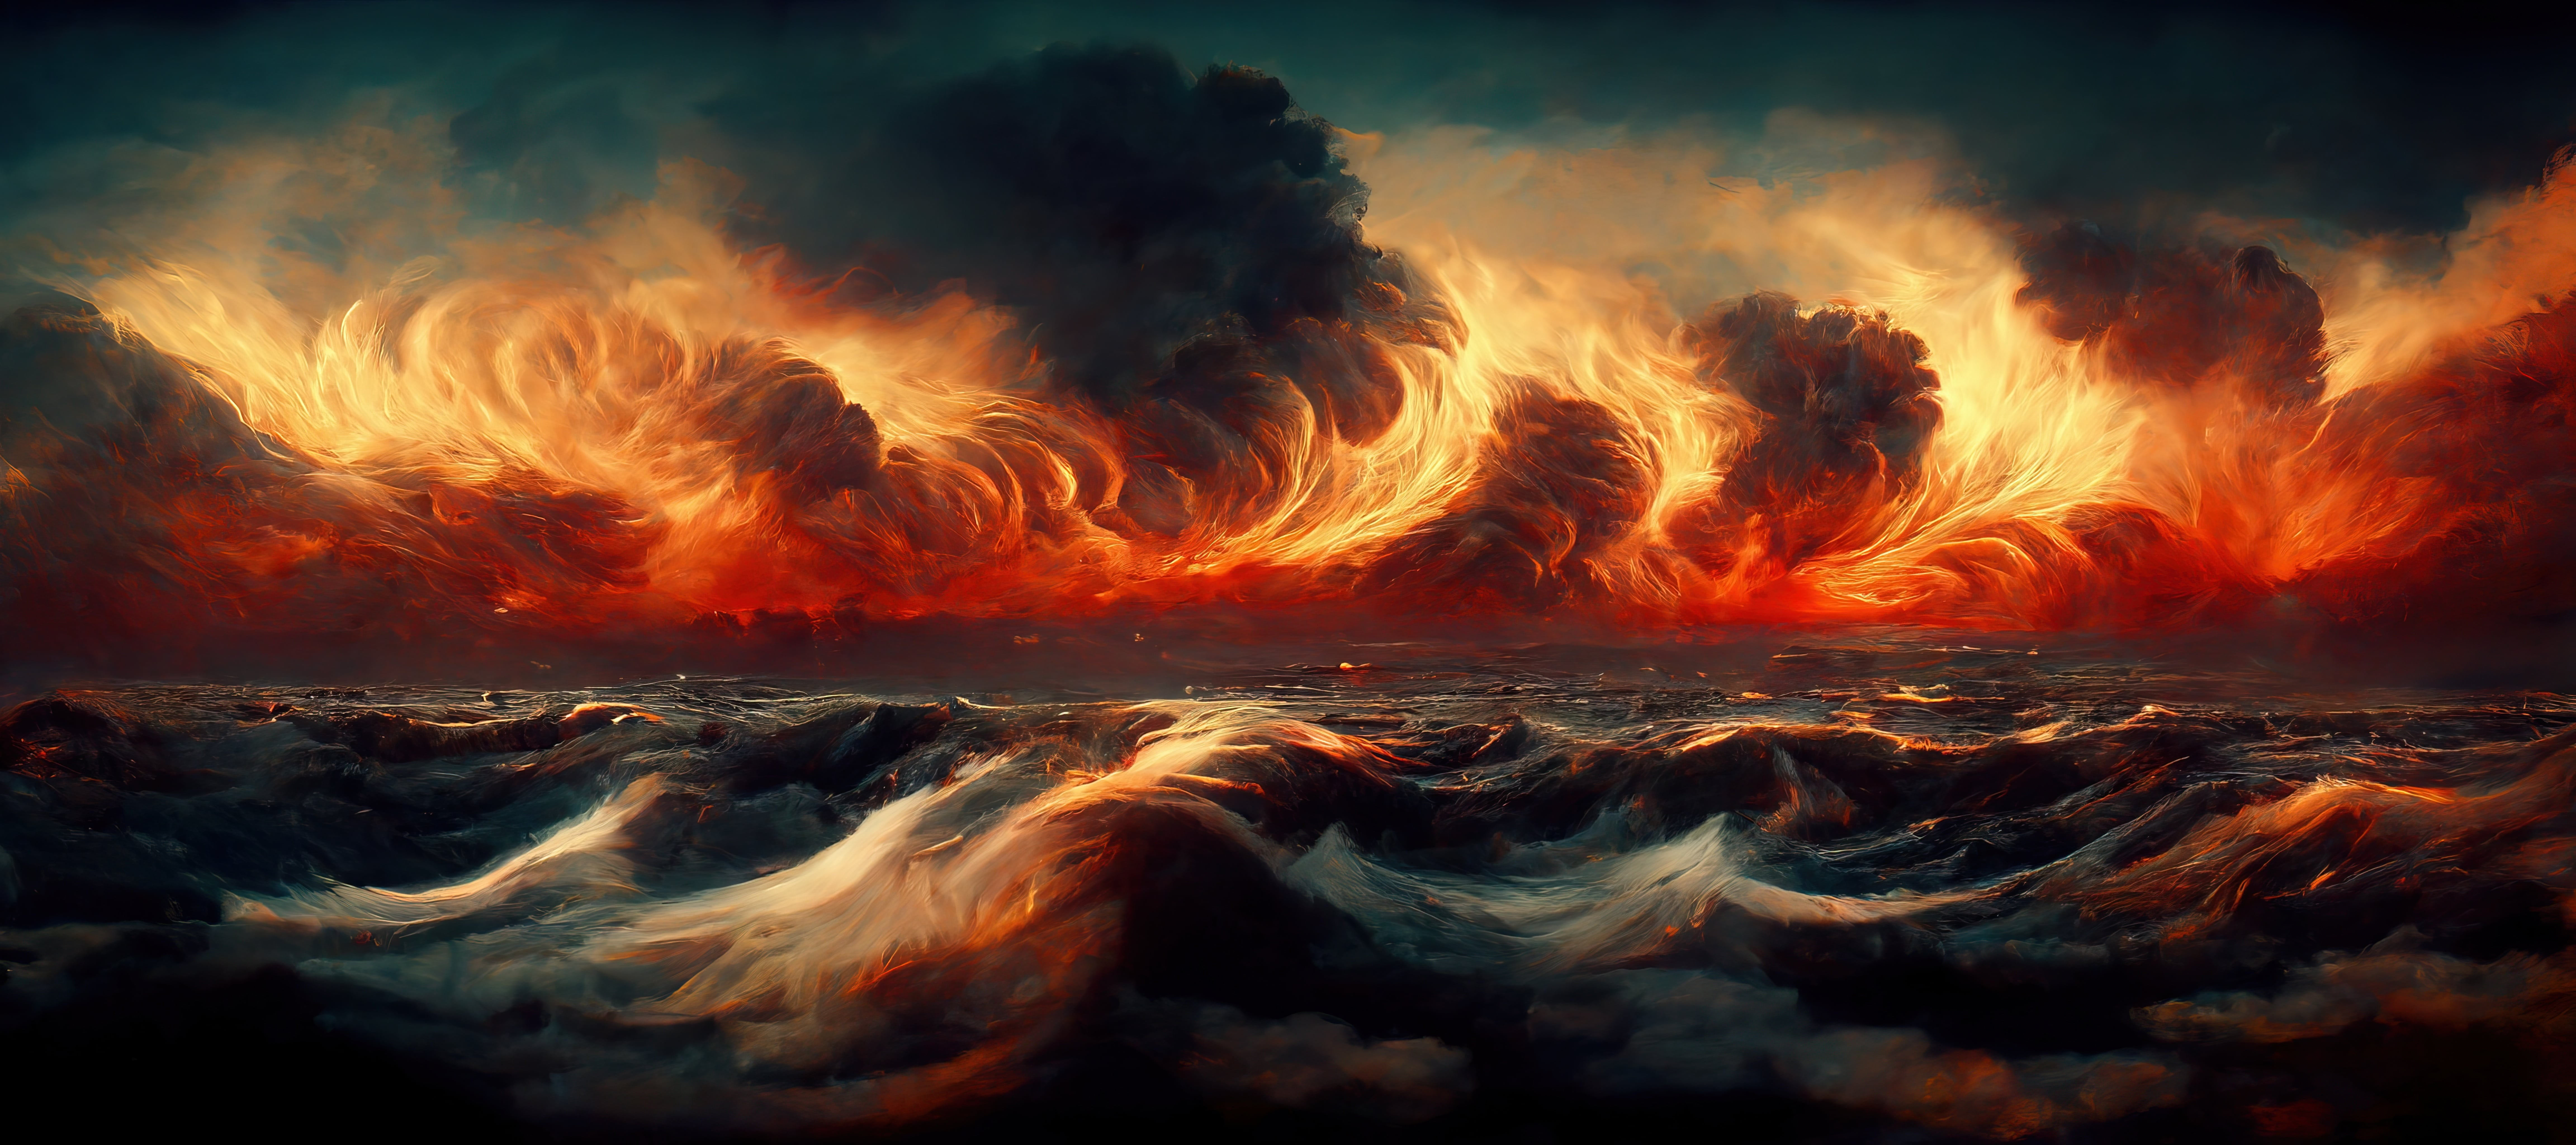

🔥 Congratulations: You can now use your physical knowledge to create machine learning algorithms that are robust to changes in their inputs!

And with that, you are officially done with the exercises of Tier 2: Well-done 🎉

*Source: Art by [SoulMyst](https://stock.adobe.com/ch_de/contributor/210533293/soulmyst?load_type=author&prev_url=detail) licensed under the [Adobe Stock standard license](https://stock.adobe.com/license-terms)* 